In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from otofu.jasmine import HZperiod, get_mtticks, assign_snHZ

import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='san-serif')
from matplotlib import rc
rc('text', usetex=True)

In [2]:
d = pd.HDFStore('compiled_catalog.h5')
datakeys = [k[1:] for k in d.keys()]
datakeys = list(np.array(datakeys)[[0,1,3,2]]) # change order
datadict = dict(zip(datakeys, [d[key] for key in datakeys]))
datalist = [assign_snHZ(d[key], 'mass', 'rad', 'Teff', 'Jmag', 'Hmag') for key in datakeys]
d.close()
print (datakeys)

Hw outside the valid range: [7.756708395177219, 12.756708395177219]
Hw outside the valid range: [7.756708395177219, 12.756708395177219]
Hw outside the valid range: [7.756708395177219, 12.756708395177219]
Hw outside the valid range: [7.756708395177219, 12.756708395177219]
['TESS candidate', 'TESS confirmed', 'Kepler/K2', 'ground']


In [18]:
m0 = np.linspace(0.03, 0.65, 100)
phz0 = HZperiod(m0, s=0.85)
phz0_upp = HZperiod(m0, s=0.25)
mticks, tticks = get_mtticks()
sn_threshold = 10.
sn_max = 30.

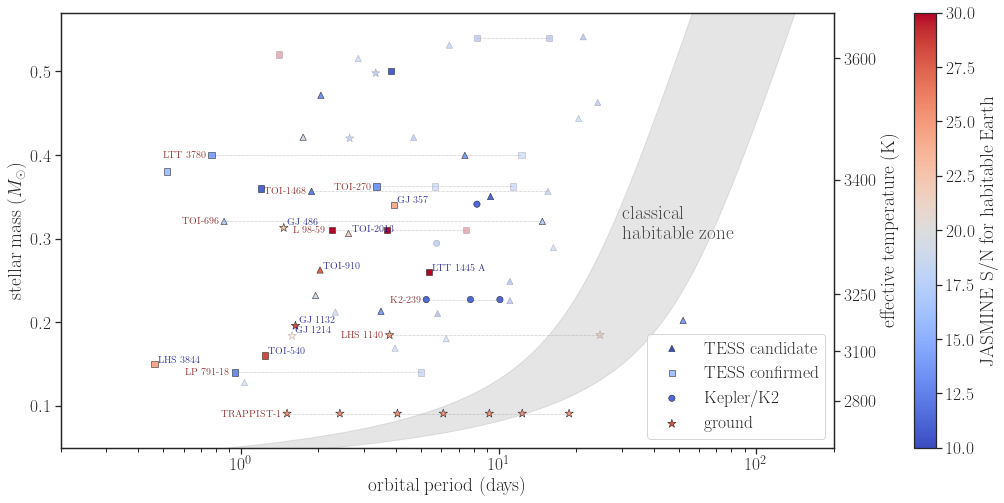

In [22]:
fig = plt.figure(figsize=(18,8))
ax = fig.gca()
ax.set_ylabel("stellar mass ($M_\odot$)")
ax.set_xlabel("orbital period (days)")
#plt.yscale('log')
plt.xscale('log')
plt.ylim(0.05, 0.57)
xkey, ykey = 'pl_orbper', 'pl_rade'
xkey, ykey = 'pl_orbper', 'mass'
ax.fill_betweenx(m0, phz0, phz0_upp, color='gray', alpha=0.2)
ax.text(30, 0.3, "classical\nhabitable zone", color='k', zorder=1000, alpha=0.8)

for df, mk, lab, ms in zip(datalist, ['^', 's', 'o', '*'], ['TESS candidate', 'TESS confirmed', "Kepler/K2", "ground"], [40, 40, 40, 80]):
    #_df = df[['tid', 'pl_rade']].groupby('tid', as_index=False).max()
    #df = pd.merge(df, _df.rename({"pl_rade": "maxrade"}, axis='columns'), on='tid')
 
    # <1.5Re planets
    _idx = (df['snHZ'] > sn_threshold) & (df.pl_rade < 1.5)
    plt.scatter(df[_idx][xkey], df[_idx][ykey], alpha=1, c=df[_idx].snHZ, vmin=sn_threshold, vmax=sn_max, cmap='coolwarm', 
                edgecolors='k', lw=0.5, marker=mk, label=lab, s=ms)
    if mk=='^':
        plt.colorbar(pad=0.08, label='JASMINE S/N for habitable Earth')
   
    # Earth-sized planets
    _idx = (df['snHZ'] > sn_threshold) & (df.pl_rade >= 1.5)
    plt.scatter(df[_idx][xkey], df[_idx][ykey], alpha=0.3, c=df[_idx].snHZ, vmin=sn_threshold, vmax=sn_max, cmap='coolwarm',
    edgecolors='k', lw=0.5, marker=mk, s=ms)
    
    _idx = (df['snHZ'] > sn_threshold)
    _tids = list(set(df[_idx].tid))
    for _tid in _tids:
        __idx = _idx & (df.tid==_tid)
        plt.plot(df[__idx][xkey], df[__idx][ykey], ls='dotted', lw=0.5, color='gray')
        
        if (np.sum(__idx&(df.mass<0.5)) > 1):
            #print (df[__idx][['pl_name', 'hostname', 'mass', 'pl_orbper', 'pl_rade', 'pHZ', 'snHZ', "Hwmag"]])
            #ax.text(np.min(df[__idx]['pl_orbper'])*0.05+0.1, df[__idx]['mass'].iloc[0], df[__idx]['hostname'].iloc[0], color='k', zorder=1000, alpha=0.8, va='center', fontsize=10)
            ax.text(np.min(df[__idx]['pl_orbper'])*0.95, df[__idx]['mass'].iloc[0], df[__idx]['hostname'].iloc[0], 
                    zorder=1000, alpha=0.8, va='center', ha='right', fontsize=10, color='maroon')
        
        if (np.sum(__idx&(df.mass<0.5)) == 1 and df[__idx].snHZ.iloc[0] > 20):
            ax.text(np.min(df[__idx]['pl_orbper'])*1.03, df[__idx]['mass'].iloc[0], df[__idx]['hostname'].iloc[0],
                    zorder=1000, alpha=0.8, va='bottom', ha='left', fontsize=10, color='darkblue')
        
plt.legend(loc='lower right')
plt.xlim(0.2, 200)

ax2 = ax.twinx()
ax2.set_yticks(mticks)
ax2.set_yticklabels(['${0:d}$'.format(int(t)) for t in tticks])
ax2.set_ylabel("effective temperature (K)")
ax2.set_ylim(0.05, 0.55)
plt.savefig("select_targets.png", dpi=200, bbox_inches="tight")